In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = 'BigEarthNet'
model = 'cvit_base_patch16_224'
name = 'mae_cvit_0.25'
metric = 'mAP' if dataset == 'BigEarthNet' else 'image_acc'

In [34]:
path = f'./results/logs/{dataset}_{model}_{name}/ft_metrics.csv'
df = pd.read_csv(path)
df.sort_values(by=[metric], inplace=True)

In [35]:
df

,epochs,lr,weight_decay,ce,loss,image_acc,epoch,num_samples
11,10,0.00005,0.001,0.119942,0.119942,0.960000,10,5400
10,10,0.00005,0.005,0.119963,0.119963,0.960000,10,5400
8,10,0.00005,0.050,0.120065,0.120065,0.960000,10,5400
9,10,0.00005,0.010,0.120042,0.120042,0.960370,10,5400
2,10,0.00050,0.005,0.104126,0.104126,0.965926,10,5400
3,10,0.00050,0.001,0.098683,0.098683,0.966481,10,5400
23,10,0.00035,0.010,0.092622,0.092622,0.967963,10,5400
27,10,0.00035,0.001,0.094733,0.094733,0.968333,10,5400
22,10,0.00035,0.050,0.094495,0.094495,0.968704,10,5400
26,10,0.00035,0.005,0.092680,0.092680,0.969074,10,5400


<Axes: xlabel='lr', ylabel='image_acc'>

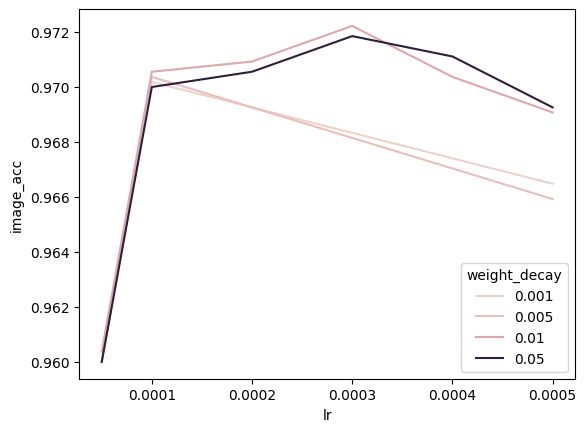

In [18]:
sns.lineplot(data=df, x='lr', y='image_acc', hue='weight_decay')

In [5]:
path = f'./results/logs/{dataset}_{model}_{name}/lp_metrics.csv'
df = pd.read_csv(path)
df.sort_values(by=[metric], inplace=True)

<Axes: xlabel='lr', ylabel='mAP'>

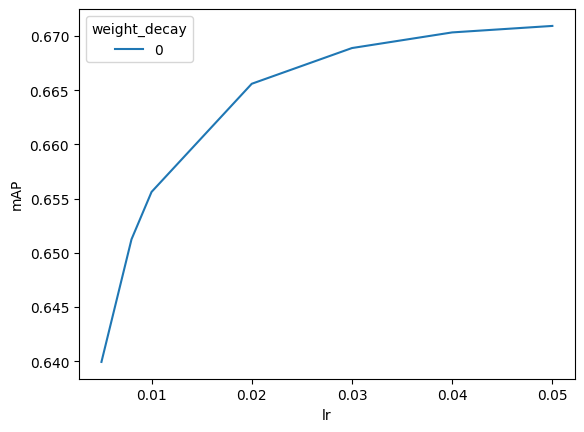

In [6]:
sns.lineplot(data=df, x='lr', y=metric, hue='weight_decay')